In [ ]:
# !pip install --upgrade --quiet openai python-dotenv
# %pip install --upgrade --quiet langchain langchain_community langchain_chroma
# %pip install --upgrade --quiet pypdf
# %pip install --upgrade --quiet -qU langchain-openai

In [1]:
import os

from openai import AzureOpenAI
from dotenv import load_dotenv
load_dotenv()

True

# Setting up configuration

In [3]:
client = AzureOpenAI(
    azure_endpoint = os.getenv('AZURE_ENDPOINT'), # os.getenv('AZURE_ENDPOINT_OLD'),
    api_key = os.getenv("AZURE_OPENAI_API_KEY"),
    api_version = os.getenv('API_VERSION')
)

In [4]:
prompt = "What is the capital of France"

response = client.chat.completions.create(
    model = os.getenv('MODEL_NAME'),
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": prompt},
    ]
)

print(response.choices[0].message.content)

The capital of France is Paris.


# RAG (Retrival Augmented Generation)

***Issue:*** What about the latest papers in IJCB 2024, prompt engineering doesnt capture that knowledge?

# RAG to the rescue!

***What is RAG? :*** RAG is a technique for augmenting LLM knowledge with additional data/current knowledge

Lets get some papers from the conference and the try asking the same question again

[Start building RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/): Components of RAG are below:
1. Indexing:
*   Load
*   Split
*   Store

2. Retrieval and Generation:   
*   Retrieve
*   Generate

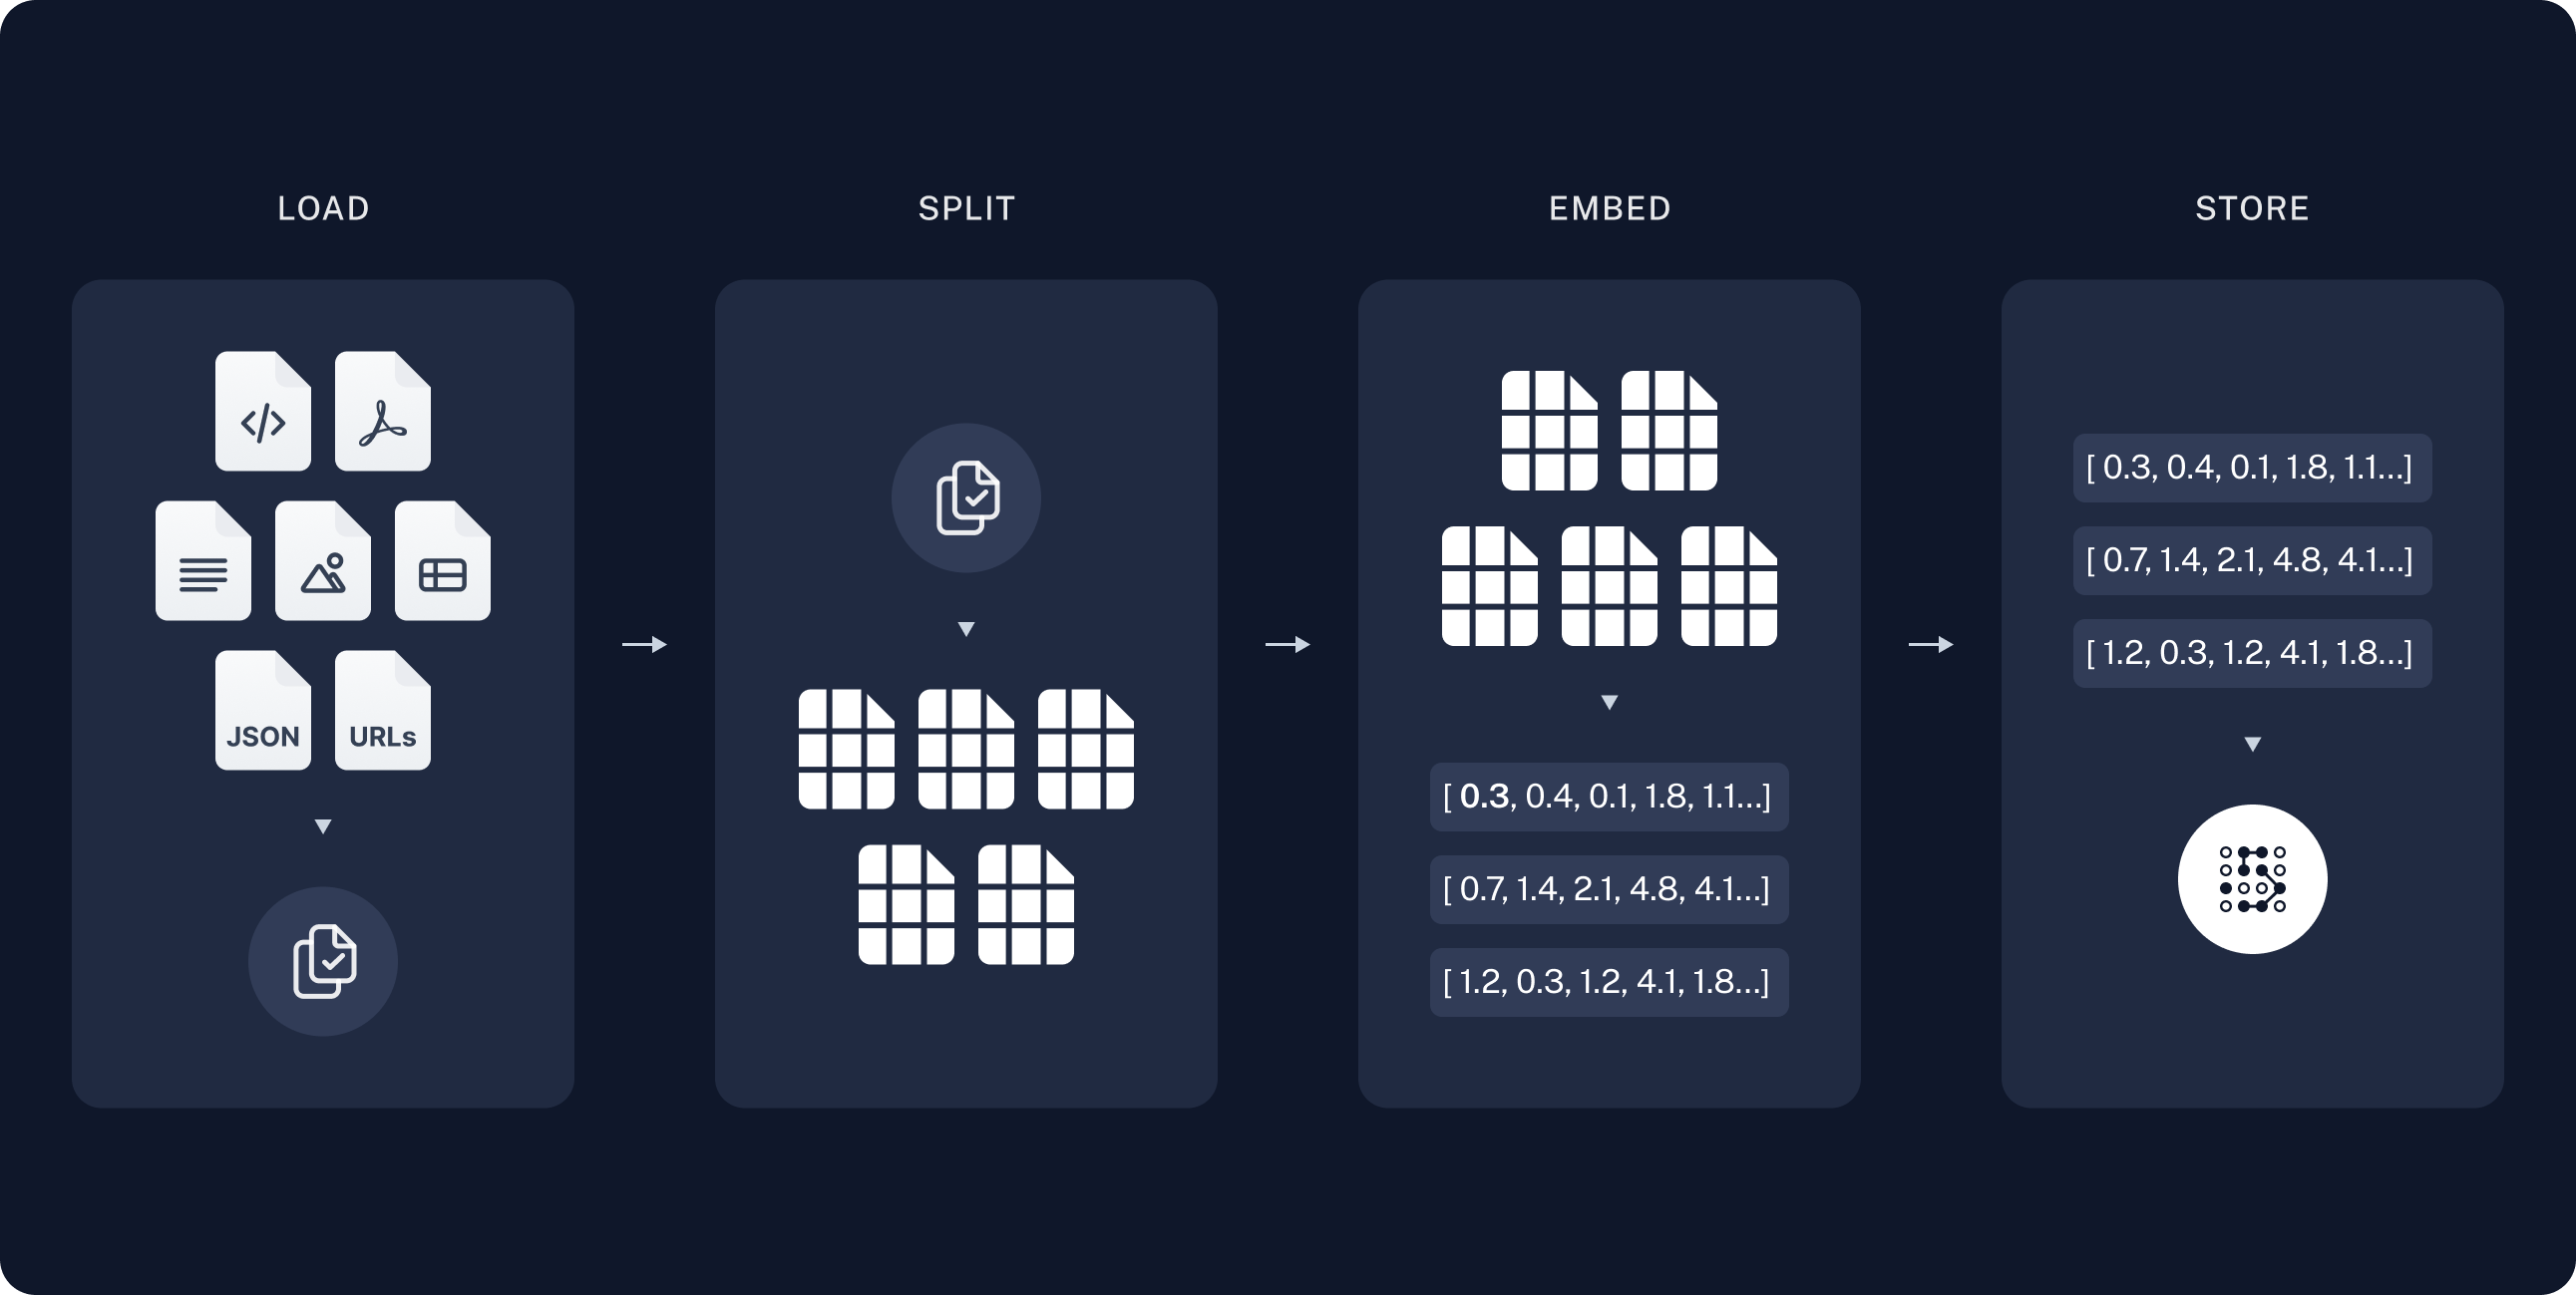

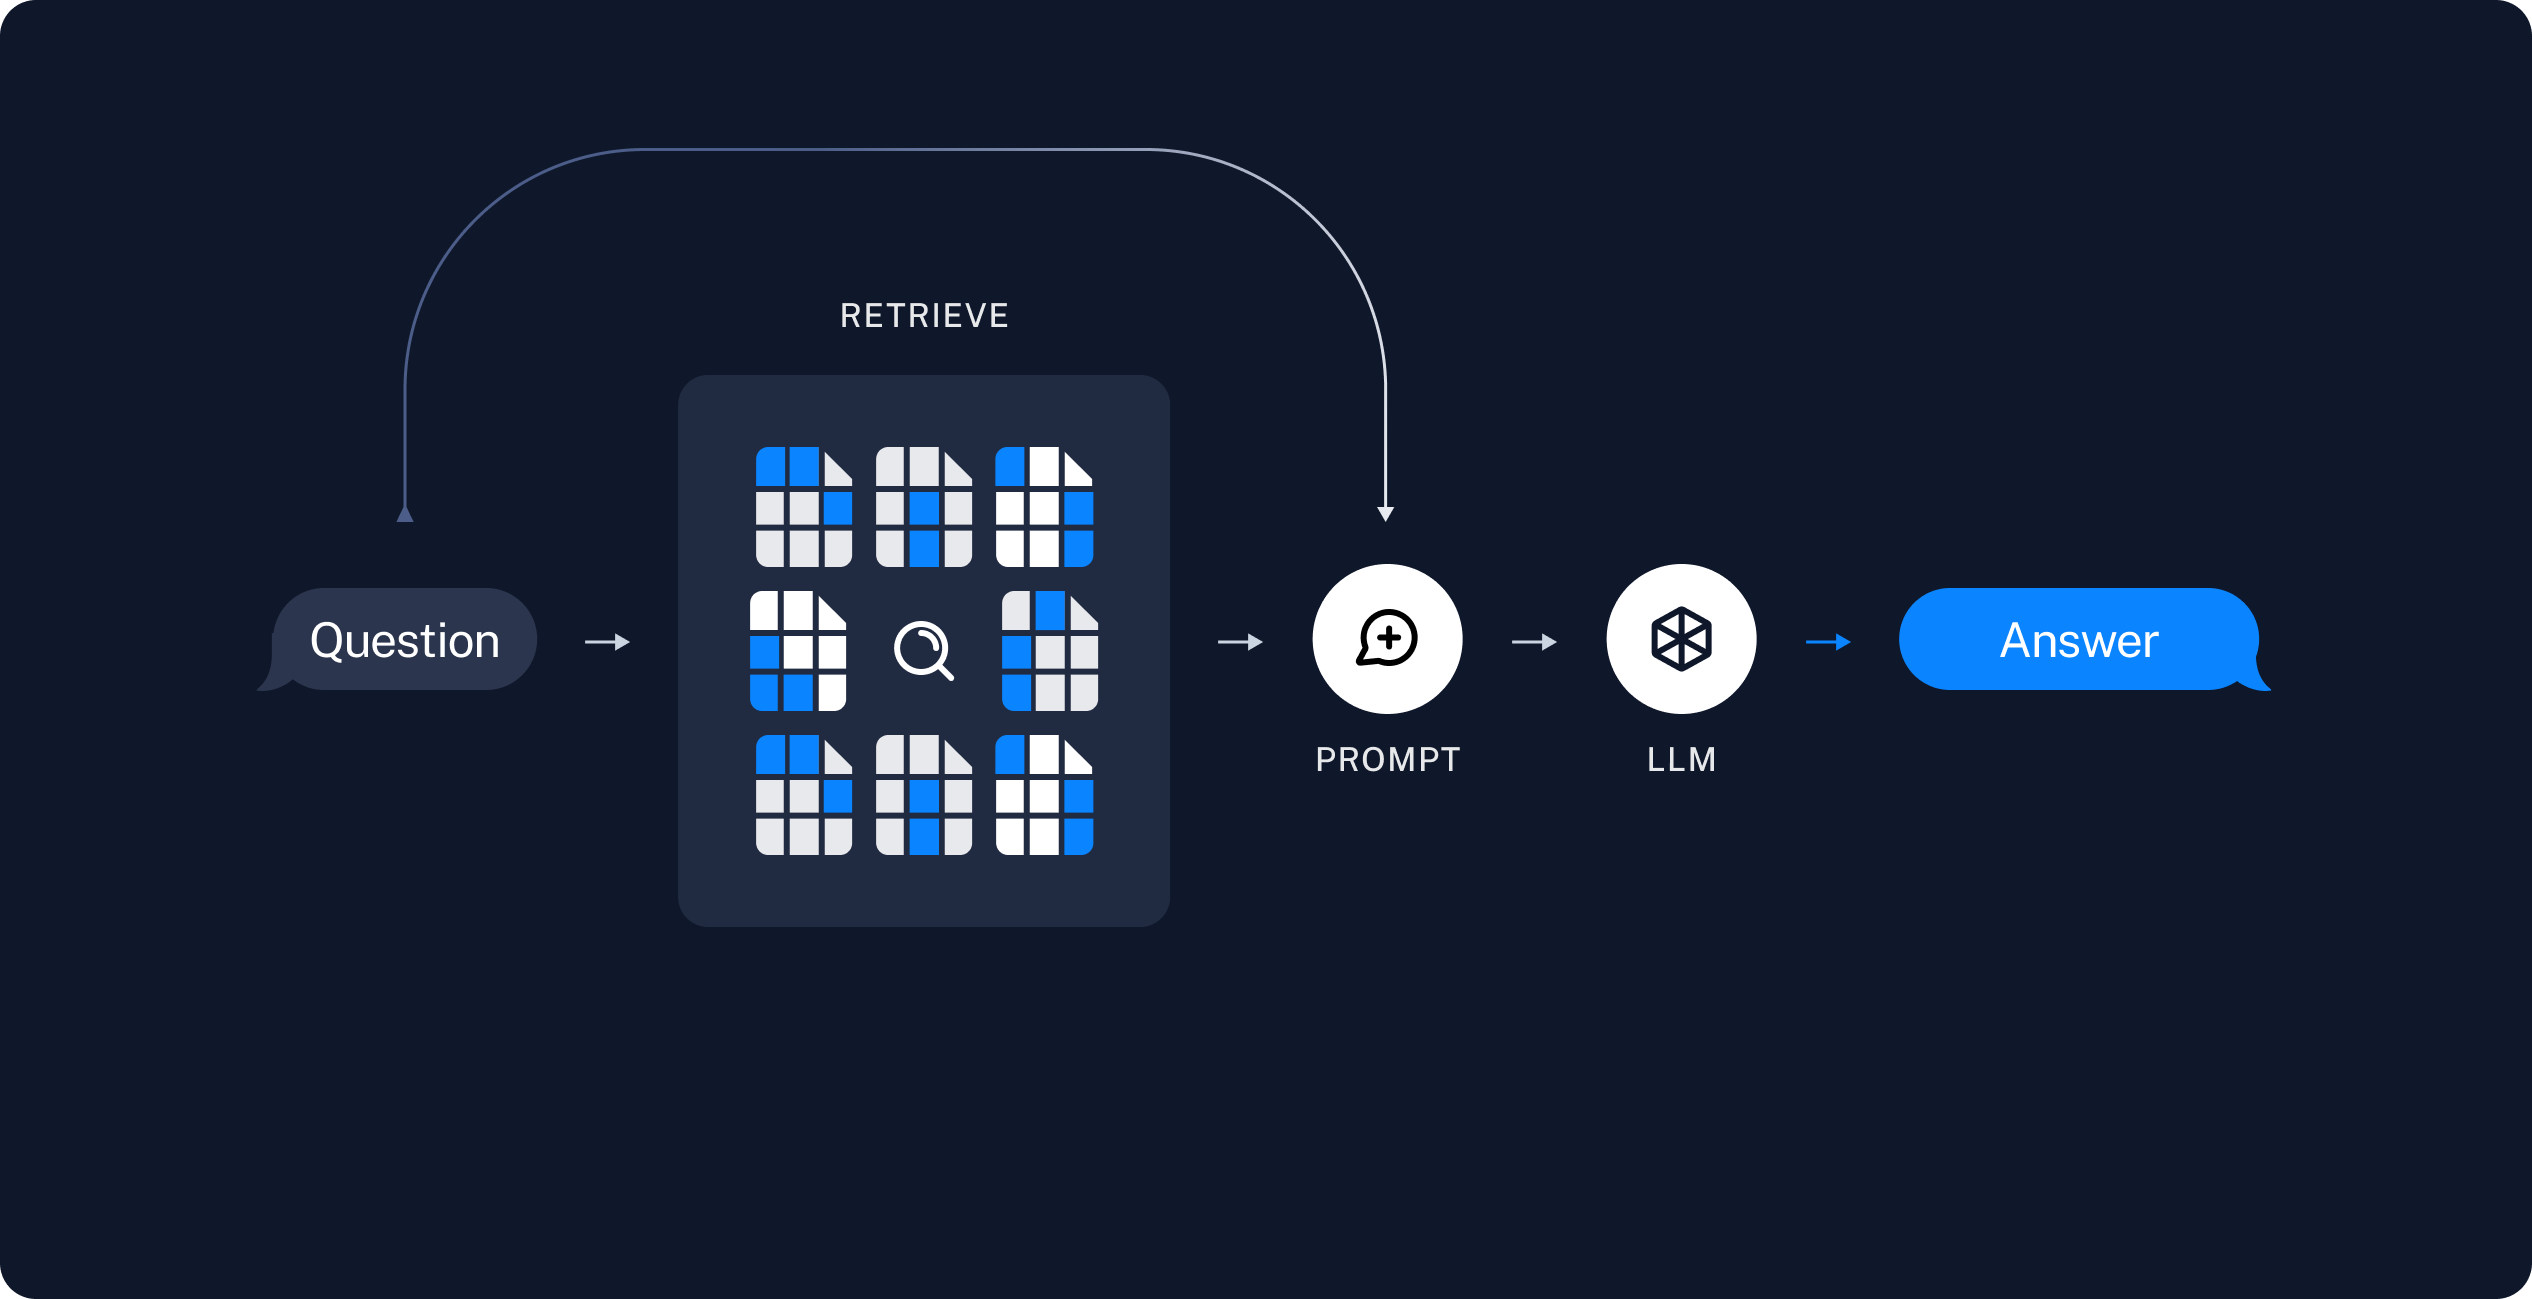

# Load and Split:
First we need to load our data. This is done with[ Document Loaders.](https://python.langchain.com/v0.2/docs/how_to/#document-loaders)

Since our papers are in pdf format, lets use pdf loader, to load and split the papers in chunks of text.

In [6]:
#Load few papers

from langchain.document_loaders import PyPDFLoader
file_paths = [
    "paper/Keystroke_Dynamics_Against_Academic_Dishonesty_LLMAge.pdf",
    "paper/Kotwal_IJCB-2_2024.pdf",
    "paper/Long_Range_Biometric_Identification_Evaluation_Framework.pdf",
]

all_pages = []
for file_path in file_paths:
  loader = PyPDFLoader(file_path)
  pages = loader.load_and_split()
  all_pages.extend(pages)

print("Length of pages: ", len(all_pages))
print("Content of a page:", all_pages[0])


Length of pages:  50
Content of a page: page_content='Keystroke Dynamics Against Academic Dishonesty in the Age of LLMs
Debnath Kundu†, 1, Atharva Mehta†, 2, Rajesh Kumar‡, 3
Naman Lal†, 4, Avinash Anand†, 5, Apoorv Singh†, 6, Rajiv Ratn Shah†, 7
†MIDAS Lab IIIT Delhi India,‡Bucknell University USA
{1debnath22026 ,2atharva20038 }@iiitd.ac.in ,3rajesh.kumar@bucknell.edu
4namanlal.lal@gmail.com ,{5avinasha,6apoorv17027,7rajivratn }@iiitd.ac.in
Abstract
The transition to online examinations and assignments
raises significant concerns about academic integrity.
Traditional plagiarism detection systems often struggle to
identify instances of intelligent cheating, particularly when
students utilize advanced generative AI tools to craft their
responses. This study proposes a keystroke dynamics-based
method to differentiate between bona fide and assisted
writing within academic contexts. To facilitate this, a
dataset was developed to capture the keystroke patterns of
individuals engaged in writ

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(all_pages)

print("Number of splits: ", len(splits))
print("Splits metadata: ", splits[0].metadata)
print("Splits content: ", splits[0].page_content)

Number of splits:  186
Splits metadata:  {'source': 'paper/Keystroke_Dynamics_Against_Academic_Dishonesty_LLMAge.pdf', 'page': 0}
Splits content:  Keystroke Dynamics Against Academic Dishonesty in the Age of LLMs
Debnath Kundu†, 1, Atharva Mehta†, 2, Rajesh Kumar‡, 3
Naman Lal†, 4, Avinash Anand†, 5, Apoorv Singh†, 6, Rajiv Ratn Shah†, 7
†MIDAS Lab IIIT Delhi India,‡Bucknell University USA
{1debnath22026 ,2atharva20038 }@iiitd.ac.in ,3rajesh.kumar@bucknell.edu
4namanlal.lal@gmail.com ,{5avinasha,6apoorv17027,7rajivratn }@iiitd.ac.in
Abstract
The transition to online examinations and assignments
raises significant concerns about academic integrity.
Traditional plagiarism detection systems often struggle to
identify instances of intelligent cheating, particularly when
students utilize advanced generative AI tools to craft their
responses. This study proposes a keystroke dynamics-based
method to differentiate between bona fide and assisted
writing within academic contexts. To facilitate t

Embed and Store the chunked text

In [8]:
from langchain_chroma import Chroma

from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    model=os.getenv('MODEL_NAME_EMBEDDING'),
    azure_endpoint = os.getenv('AZURE_ENDPOINT'),
    api_key = api_key,
    api_version = os.getenv('API_VERSION')
)

vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

# UseCase #1: Search and Retrieve

In [12]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})
retrieved_docs = retriever.invoke("Tell me about latest research of using foundational AI in Biometrics")

print("Number of docs retrieved: ", len(retrieved_docs))
print("Content of one doc: \n", retrieved_docs[0].page_content)

Number of docs retrieved:  6
Content of one doc: 
 able datasets on which to train and evaluate new biometric
models. Authors in [16] and [20] demonstrate the need for
systems in low-resolution and unconstrained collection en-
vironments. Research such as [18], [25], [19], and [27] ex-
plore the impact that the number of pixels on the face as well
as the quality of the face video itself have on facial recog-
nition systems, which has spurred entities such as IARPA
and DARPA to invest in datasets that can help improve bio-metric performance at long ranges and lower qualities [9, 8]
The utility for facial recognition systems that can perform
accurately at long distances is also addressed in [4] and [21].
In recent years, the prevalence of high-quality, lower cost
UA Vs has lead to their widespread usage for various appli-
cations. Those systems with mid-to-high quality imaging
sensors lend themselves especially to use cases involving
human detection, identification and tracking. Research

# Use Case #2: Question Answering using RAG

In [13]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

print(example_messages[0].content)

c:\Users\asankaran\AppData\Local\anaconda3\envs\pyrit\lib\site-packages\langsmith\client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question 
Context: filler context 
Answer:


c:\Users\asankaran\AppData\Local\anaconda3\envs\pyrit\lib\site-packages\langsmith\client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [14]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment=os.getenv("MODEL_NAME_BIG"),
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    openai_api_key=api_key,
    api_version=os.getenv("API_VERSION"),
    verbose=False,
    temperature=0.3,
)

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("Who are authors of few latst papers in biometrics ??"):
    print(chunk, end="", flush=True)


Some authors of recent papers in biometrics include Alejandro Acien, Aythami Morales, John V. Monaco, Ruben Vera-Rodriguez, Julian Fierrez, Ahmed Wahab, and Daqing Hou.